# Quantum Image Processing

In this notebook we will see how to encode images with the FRQI and NEQR techniques

You can find an introduction at the following link:
[Qiskit](https://qiskit.org/textbook/ch-applications/image-processing-frqi-neqr.html)

In [1]:
%matplotlib inline
from qiskit import QuantumRegister, QuantumCircuit
from qiskit.providers.aer import AerSimulator
from qiskit import transpile, assemble
from qiskit.circuit.library.standard_gates import RYGate

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import math

#### Create or Load your Images

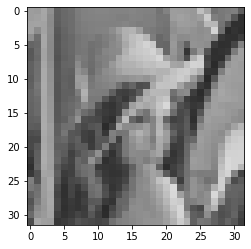

In [2]:
# Resize dimensions
w, h = 32, 32
# Define the rotational angles
angles = [0]#, -10, -20, -30, -40, -50]

# Load and resize an image
jpg_image = Image.open("lena.jpg").resize((w, h))

# Load and turn all images
image = np.zeros((h, w*len(angles)))

for i, theta in enumerate(angles):
    image[:, i*w:(i + 1)*w] = np.asarray(jpg_image.rotate(theta))

plt.imshow(image, cmap='gray', vmin=0, vmax=255)


# Create your image
# image = np.asarray([[0, 15, 30, 45],
#                     [60, 75, 90, 105],
#                     [120, 135, 150, 165],
#                     [180, 195, 210, 225]])

plt.imshow(image, cmap='gray', vmin=0, vmax=255)

## FRQI: Flexible Representation of Quantum Images

\begin{equation*}
\left|I(\theta)\right\rangle =
    \frac{1}{2^n}\sum_{i=0}^{2^{2n-1}}
        \left( cos(\theta_i)\left| 0 \right\rangle + sin(\theta_i)\left| 1 \right\rangle \right)
        \otimes \left| i \right\rangle
\end{equation*}

In [ ]:
# Define the number of qubits needed to store the image positions
num_rows, num_cols = image.shape

# Scale the intensity inside [0, pi/2]
scaled_img = (np.pi/2)*(image / 255)

# Image size
height = QuantumRegister(math.ceil(np.log2(num_rows)), 'height')
width = QuantumRegister(math.ceil(np.log2(num_cols)), 'width')

# Grayscale pixel intensity value
intensity = QuantumRegister(1, 'intensity')

# Set the total number of qubits
num_qubits = intensity.size + width.size + height.size

# create the quantum circuit for the image
qc_image = QuantumCircuit(height, width, intensity, name='Image Encoding')

# create a larger circuit to integrate the quantum image encoding
qc = QuantumCircuit(height, width, intensity)

# Add Hadamard gates to store the rows and columns of the image
for i in range(height.size + width.size):
    qc_image.h(i)

# For every pixel
for j in range(num_cols):
    for i in range(num_rows):

        # Separate with barrier so it is easy to read later.
        qc_image.barrier()

        # Encode pixel position in binary format:
        x = np.binary_repr(j, width=width.size)
        y = np.binary_repr(i, width=height.size)

        # Encode x position
        for idx, ctr in enumerate(x[::-1]):

            # Add a X Gate
            if ctr == '1':
                qc_image.x(height.size + idx)

        # Encode y position
        for idy, ctr in enumerate(y[::-1]):

            # Add a X Gate
            if ctr == '1':
                qc_image.x(idy)

        # Encode pixel values as rotational angle:
        qc_image.append(RYGate(2*scaled_img[i, j]).control(width.size + height.size),
                        list(range(intensity.size + width.size + height.size)))

        # if i == num_rows - 1 and j < num_cols - 1:
        # Restore x position
        for idx, ctr in enumerate(x[::-1]):

            # Add a X Gate
            if ctr == '1':
                qc_image.x(height.size + idx)

        # Restore y position
        for idy, ctr in enumerate(y[::-1]):

            # Add a X Gate
            if ctr == '1':
                qc_image.x(idy)

qc.append(qc_image.to_instruction(), list(range(0, qc_image.num_qubits)))

qc.measure_all()

qc.draw()

Circuit dimensions
Circuit depth:  5238273
Circuit size:  7342090


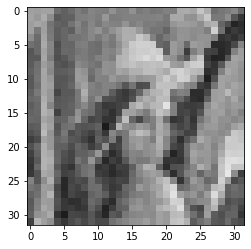

In [21]:
# Initialize the simulator
aer_sim = AerSimulator()
# Run the simulation
num_of_shots = 100000
t_qc = transpile(qc, aer_sim)
qobj = assemble(t_qc, shots=num_of_shots)
job = aer_sim.run(qobj)
counts = job.result().get_counts()
# Evaluate the depth of the circuit
print('Circuit dimensions')
print('Circuit depth: ', qc_image.decompose().depth())
print('Circuit size: ', qc_image.decompose().size())


# Convert and store the output image
scale_factor = len(counts.items()) / num_of_shots
cosine, sine  = np.zeros(image.shape), np.zeros(image.shape)
output_image = np.zeros(image.shape)

# Decode each outcome
for bits in counts.items():

    y = int(bits[0][1:width.size + 1], 2)
    x = int(bits[0][width.size + 1:width.size + height.size + 1], 2)


    if bits[0][0] == '0':
        cosine[x, y] = np.sqrt(scale_factor * bits[1])
    else:
        sine[x, y] = np.sqrt(scale_factor * bits[1])

# For every pixel
for i in range(num_cols):
    for j in range(num_rows):
        output_image[num_rows - j - 1][num_cols - i - 1] = \
            int(255 * (np.arctan2(sine[j][i], cosine[j][i]) / (np.pi / 2)))

plt.imshow(output_image, cmap='gray', vmin=0, vmax=255)

## NEQR: A Novel Enhanced Quantum Representation of Digital Images

In [22]:
# Define the number of qubits needed to store the image positions
num_rows, num_cols = image.shape

# Image size
height = QuantumRegister(math.ceil(np.log2(num_rows)), 'height')
width = QuantumRegister(math.ceil(np.log2(num_cols)), 'width')

# grayscale pixel intensity value
intensity = QuantumRegister(8, 'intensity')

# set the total number of qubits
num_qubits = intensity.size + width.size + height.size

# create the quantum circuit for the image
qc_image = QuantumCircuit(intensity, height, width, name='Image Encoding')

# create a larger circuit to integrate the quantum image encoding
qc = QuantumCircuit(intensity, height, width)

# Optional: Add Identity gates to the intensity values
for i in range(intensity.size):
    qc_image.i(i)

# Add Hadamard gates to store the rows of the image
for x in range(height.size):
    qc_image.h(intensity.size + x)

# Add Hadamard gates to store the columns of the image
for y in range(width.size):
    qc_image.h(intensity.size + height.size + y)


# For every pixel
for i in range(num_rows):
    for j in range(num_cols):

        # Separate with barrier so it is easy to read later.
        qc_image.barrier()

        # Encode pixel position in binary format:
        y = np.binary_repr(i, width=height.size)
        x = np.binary_repr(j, width=width.size)

        # Encode x position
        for idx, ctr in enumerate(x[::-1]):

            # Add a X Gate
            if ctr == '1':
                qc_image.x(intensity.size + height.size + idx)

        # Encode y position
        for idy, ctr in enumerate(y[::-1]):

            # Add a X Gate
            if ctr == '1':
                qc_image.x(intensity.size + idy)


        # Encode pixel values in binary format:
        pixel = np.binary_repr(int(image[i, j]), width=intensity.size)

        for idx, px in enumerate(pixel[::-1]):

            # add a control not gate
            if px == '1':
                qc_image.mcx(list(range(intensity.size, num_qubits)), idx)

        # Restore the original
        # Encode x position
        for idx, ctr in enumerate(x[::-1]):

            # Add a X Gate
            if ctr == '1':
                qc_image.x(intensity.size + height.size + idx)

        # Encode y position
        for idy, ctr in enumerate(y[::-1]):

            # Add a X Gate
            if ctr == '1':
                qc_image.x(intensity.size + idy)


qc.append(qc_image.to_instruction(), list(range(0, qc_image.num_qubits)))

qc.measure_all()

qc.draw()


┌──────────────────┐ ░ ┌─┐                                       »
intensity_0: ┤0                 ├─░─┤M├───────────────────────────────────────»
             │                  │ ░ └╥┘┌─┐                                    »
intensity_1: ┤1                 ├─░──╫─┤M├────────────────────────────────────»
             │                  │ ░  ║ └╥┘┌─┐                                 »
intensity_2: ┤2                 ├─░──╫──╫─┤M├─────────────────────────────────»
             │                  │ ░  ║  ║ └╥┘┌─┐                              »
intensity_3: ┤3                 ├─░──╫──╫──╫─┤M├──────────────────────────────»
             │                  │ ░  ║  ║  ║ └╥┘┌─┐                           »
intensity_4: ┤4                 ├─░──╫──╫──╫──╫─┤M├───────────────────────────»
             │                  │ ░  ║  ║  ║  ║ └╥┘┌─┐                        »
intensity_5: ┤5                 ├─░──╫──╫──╫──╫──╫─┤M├────────────────────────»
             │                  │ ░  ║  ║  ║  ║  ║ └╥┘┌─┐                     »
intensity_6: ┤6                 ├─░──╫──╫──╫──╫──╫──╫─┤M├─────────────────────»
             │                  │ ░  ║  ║  ║  ║  ║  ║ └╥┘┌─┐                  »
intensity_7: ┤7                 ├─░──╫──╫──╫──╫──╫──╫──╫─┤M├──────────────────»
             │                  │ ░  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐               »
   height_0: ┤8                 ├─░──╫──╫──╫──╫──╫──╫──╫──╫─┤M├───────────────»
             │   Image Encoding │ ░  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐            »
   height_1: ┤9                 ├─░──╫──╫──╫──╫──╫──╫──╫──╫──╫─┤M├────────────»
             │                  │ ░  ║  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐         »
   height_2: ┤10                ├─░──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫─┤M├─────────»
             │                  │ ░  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐      »
   height_3: ┤11                ├─░──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫─┤M├──────»
             │                  │ ░  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐   »
   height_4: ┤12                ├─░──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫─┤M├───»
             │                  │ ░  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐»
    width_0: ┤13                ├─░──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫─┤M├»
             │                  │ ░  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘»
    width_1: ┤14                ├─░──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫─»
             │                  │ ░  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║ »
    width_2: ┤15                ├─░──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫─»
             │                  │ ░  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║ »
    width_3: ┤16                ├─░──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫─»
             │                  │ ░  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║ »
    width_4: ┤17                ├─░──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫─»
             └──────────────────┘ ░  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║ »
    meas: 18/════════════════════════╩══╩══╩══╩══╩══╩══╩══╩══╩══╩══╩══╩══╩══╩═»
                                     0  1  2  3  4  5  6  7  8  9  10 11 12 13»
«                         
«intensity_0: ────────────
«                         
«intensity_1: ────────────
«                         
«intensity_2: ────────────
«                         
«intensity_3: ────────────
«                         
«intensity_4: ────────────
«                         
«intensity_5: ────────────
«                         
«intensity_6: ────────────
«                         
«intensity_7: ────────────
«                         
«   height_0: ────────────
«                         
«   height_1: ────────────
«                         
«   height_2: ────────────
«                         
«   height_3: ────────────
«                         
«   height_4: ────────────
«                         
«    width_0: ────────────
«             ┌─┐         
«    width_1: ┤M├─────────
«             └╥┘┌─┐      
«    width_2: ─╫─┤M├──────
«              ║ └╥┘┌─┐   
« 

### Simulation Results

Circuit dimensions
Circuit depth:  6071
Circuit size:  22324
32 32


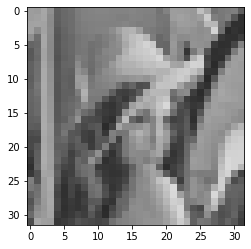

In [23]:
# Initialize the simulator
aer_sim = AerSimulator()
# Run the simulation
t_qc = transpile(qc, aer_sim)
qobj = assemble(t_qc, shots=100000)
job = aer_sim.run(qobj)
counts = job.result().get_counts()
# Evaluate the depth of the circuit
print('Circuit dimensions')
print('Circuit depth: ', qc_image.decompose().depth())
print('Circuit size: ', qc_image.decompose().size())

# Store the output image
output_image = np.zeros((image.shape[0], image.shape[1]))

print(image.shape[1], image.shape[0])

# Decode each outcome
for bits in counts.items():

    x = int(bits[0][0:width.size], 2)
    y = int(bits[0][width.size:width.size + height.size], 2)

    pixel = int(bits[0][height.size + width.size:height.size + width.size + intensity.size], 2)

    output_image[image.shape[0] - y - 1][image.shape[1] - x - 1] = pixel


plt.imshow(output_image, cmap='gray', vmin=0, vmax=255)